# Analysis of Box Office Data To Generate Insights and Provide Recommendations to the heads of Microsoft's New Film Studio

The cell below imports the various packages that we will be using in this notebook

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In the cell below, we loading our 'clean_data.csv' file as well as the 'imdb.name.basics.csv.gz' because we will be join the tables soon

In [2]:
# loading the files into a pandas dataframe
df = pd.read_csv('clean_data.csv')
imdb_name_basics = pd.read_csv('zippedData/imdb.name.basics.csv.gz') #this is to get the directors actual names!

Importing sqlite3 and setting up a connection to our 'aggregate.db'database to prepare for the joining of the above two tables.

In [3]:
# this helps us get the directors actual names later in the notebook
import sqlite3
conn = sqlite3.connect('aggregate.db')
cur = conn.cursor()

We are forming two columns for the domestic and worldwide profit, respectively by subtracting the production budget of each from their corresponding domestic and worldwide gross and adding them to the df dataframe

In [4]:
# Calculating the domestic/worldwide profit and putting them in new columns
df['domestic_profit'] = df['domestic_gross'] - df['production_budget']
df['worldwide_profit'] = df['worldwide_gross'] - df['production_budget']

df.head()

,movie,original_title,genres,directors,production_budget,domestic_gross,worldwide_gross,TN_year,TN_month,domestic_profit,worldwide_profit
0,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",nm0551128,410600000.0,241063875.0,1.045664e+09,2011,May,-169536125.0,6.350639e+08
1,Dark Phoenix,Dark Phoenix,"Action,Adventure,Sci-Fi",nm1334526,350000000.0,42762350.0,1.497624e+08,2019,Jun,-307237650.0,-2.002376e+08
2,Avengers: Age of Ultron,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",nm0923736,330600000.0,459005868.0,1.403014e+09,2015,May,128405868.0,1.072414e+09
3,Avengers: Infinity War,Avengers: Infinity War,"Action,Adventure,Sci-Fi","nm0751577,nm0751648",300000000.0,678815482.0,2.048134e+09,2018,Apr,378815482.0,1.748134e+09
4,Justice League,Justice League,"Action,Adventure,Fantasy",nm0811583,300000000.0,229024295.0,6.559452e+08,2017,Nov,-70975705.0,3.559452e+08


The monthToNum function is used to create a new column(month_num) showing the numeric equivalent of the calendar months in the TN_month column

In [5]:
# code to get the numerical equivalent of the release months
def monthToNum(month_list):
    calendar_months= {'Jan' : 1,'Feb' : 2,'Mar' : 3,'Apr' : 4,'May' : 5,'Jun' : 6,'Jul' : 7,'Aug' : 8,'Sep' : 9, 'Oct' : 10,'Nov' : 11,'Dec' : 12}
    list_month = []
    for month in month_list:
        list_month.append(calendar_months[month])
    return pd.DataFrame(list_month)
#  creating a new column with the numerical values of the months   
df['month_num'] = monthToNum(list(df['TN_month']))
df.head()

,movie,original_title,genres,directors,production_budget,domestic_gross,worldwide_gross,TN_year,TN_month,domestic_profit,worldwide_profit,month_num
0,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",nm0551128,410600000.0,241063875.0,1.045664e+09,2011,May,-169536125.0,6.350639e+08,5
1,Dark Phoenix,Dark Phoenix,"Action,Adventure,Sci-Fi",nm1334526,350000000.0,42762350.0,1.497624e+08,2019,Jun,-307237650.0,-2.002376e+08,6
2,Avengers: Age of Ultron,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",nm0923736,330600000.0,459005868.0,1.403014e+09,2015,May,128405868.0,1.072414e+09,5
3,Avengers: Infinity War,Avengers: Infinity War,"Action,Adventure,Sci-Fi","nm0751577,nm0751648",300000000.0,678815482.0,2.048134e+09,2018,Apr,378815482.0,1.748134e+09,4
4,Justice League,Justice League,"Action,Adventure,Fantasy",nm0811583,300000000.0,229024295.0,6.559452e+08,2017,Nov,-70975705.0,3.559452e+08,11


# Does the release date have to with the success of a movie?
We find ourselves asking if the time of release has an effect on the profits made from the movies. Do movies do better at certain times of the year or does it not matter when they are released?
Here we take a look at the Domestic and Worldwide mean Profits for each month by plotting a stacked barchart showing the mean profits in relation to each month.

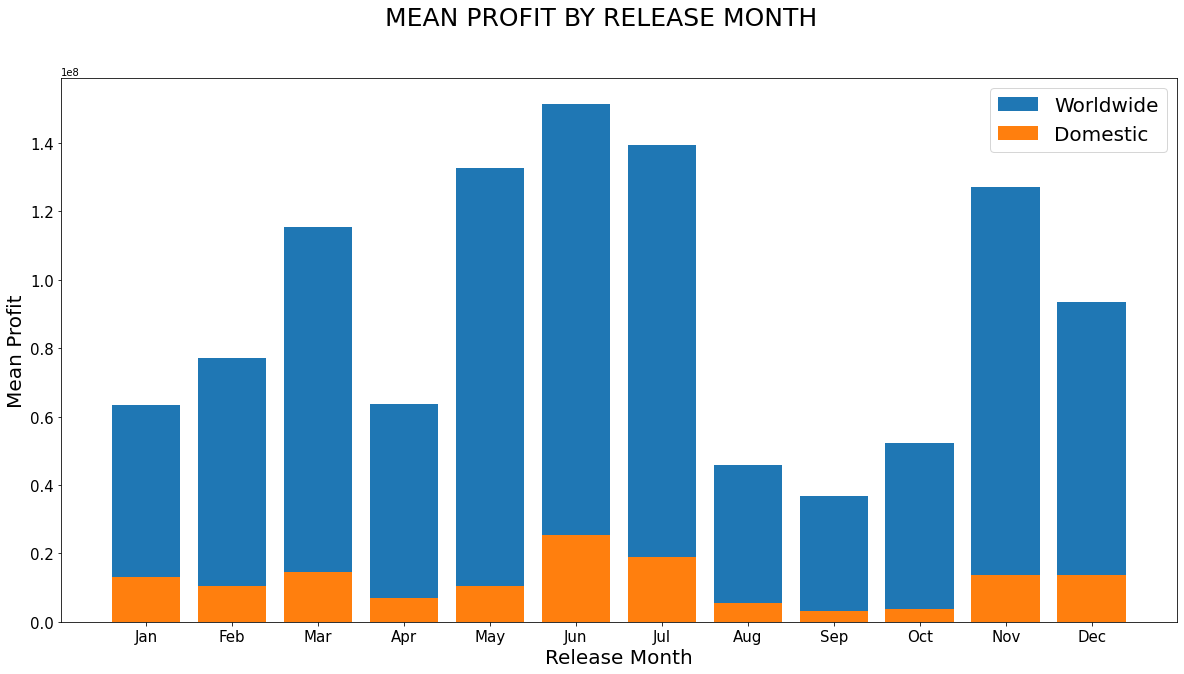

In [6]:
# calculating the mean profit for each month
domestic_profit = df.groupby('month_num')['domestic_profit'].mean()
worldwide_profit = df.groupby('month_num')['worldwide_profit'].mean()

# Plotting the Release Months against their Mean Profit (Both worldwide and Domestic)
fig, ax = plt.subplots(figsize=(20, 10))

x = domestic_profit.index
y1 = worldwide_profit.values
y2 = domestic_profit.values
ax.bar(x,y1)
ax.bar(x,y2)
plt.xticks(np.arange(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.tick_params(labelsize= 15)
ax.set_xlabel('Release Month', fontsize= 20)
ax.set_ylabel('Mean Profit',fontsize= 20)
plt.suptitle('MEAN PROFIT BY RELEASE MONTH', fontsize= 25)

ax.legend(['Worldwide', 'Domestic'], fontsize= 20)
ax.set_ylim(0);

The visualization above answers our question and leads us to believe that the months of June and July are the most profitable times to release movies overall! The month of may also has a high mean profit overall, however the domestic profit falls behind some of the other months.

# Movie Genre

There are various movie genres available for viewers to pick from but do specific genres attract a larger viewer audience? We would like to see the genres in relation to the profits made from them in order to answer this question.

In [82]:
# subsetting these columns and assigning to new variable
genre_profit = df.loc[:, ['genres', 'domestic_profit', 'worldwide_profit','production_budget']]


# exploding the genres column
genre_profit_new = genre_profit.set_index(genre_profit.columns.drop('genres',1).tolist()).genres.str.split(',', expand=True).stack().reset_index().rename(columns={0:'genres'}).loc[:, genre_profit.columns]
genre_profit_new

,genres,domestic_profit,worldwide_profit,production_budget
0,Action,-169536125.0,635063875.0,410600000.0
1,Adventure,-169536125.0,635063875.0,410600000.0
2,Fantasy,-169536125.0,635063875.0,410600000.0
3,Action,-307237650.0,-200237650.0,350000000.0
4,Adventure,-307237650.0,-200237650.0,350000000.0
...,...,...,...,...
4721,Documentary,-23453.0,-23453.0,27000.0
4722,Drama,-23453.0,-23453.0,27000.0
4723,Drama,-23453.0,-23453.0,27000.0
4724,Comedy,-4416.0,-4416.0,9000.0


The bar plot below shows us the relationship between the genres and their return profits (both domestic and worldwide). We see that genres like Musical, Scifi and Animation have a high return profit both domestic and worldwide. The adventure genre also has a high worldwide return profit, however the domestic profit fall behind a few of the other genres.

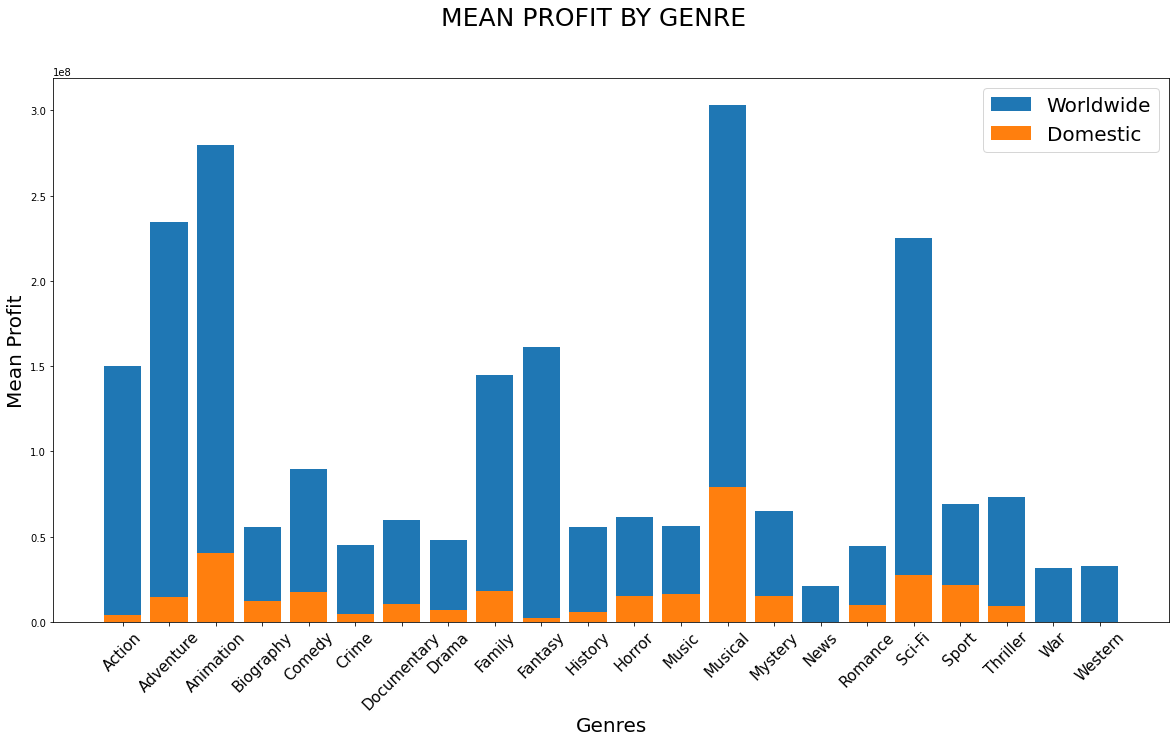

In [83]:
# calculating the mean profit for each genre
genre_domestic = genre_profit_new.groupby('genres')['domestic_profit'].mean()
genre_worldwide = genre_profit_new.groupby('genres')['worldwide_profit'].mean()

# Plotting the Genres against their Mean Profit (Both worldwide and Domestic)
fig, ax = plt.subplots(figsize=(20, 10))

x = genre_domestic.index
y1 = genre_worldwide.values
y2 = genre_domestic.values

ax.bar(x,y1)
ax.bar(x,y2)
ax.tick_params(axis='x', labelsize= 15, rotation=45)
ax.set_xlabel('Genres', fontsize= 20)
ax.set_ylabel('Mean Profit',fontsize= 20)
plt.suptitle('MEAN PROFIT BY GENRE', fontsize= 25)

ax.legend(['Worldwide', 'Domestic'], fontsize= 20)
ax.set_ylim(0);

# Mean Production Budget categorized by Genre

Below we want to take a look at the average monetary budget needed for each genre category in order to give our client an idea of the amount of funds that would be needed

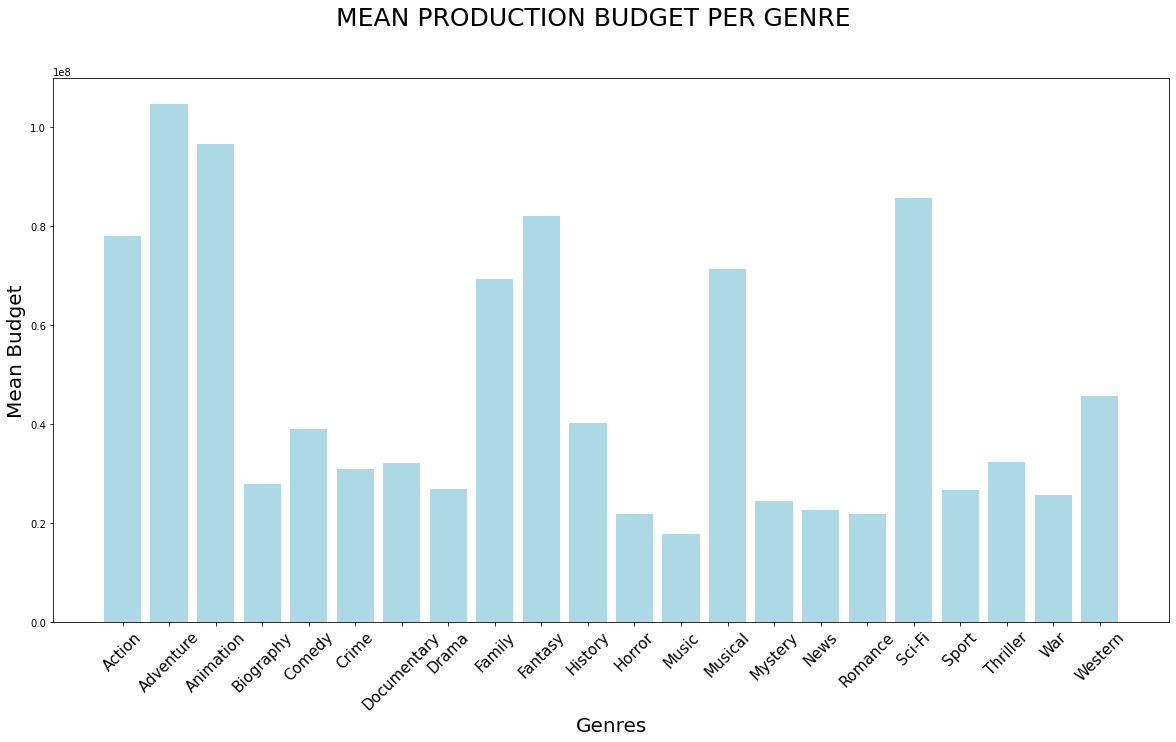

In [104]:
# calculating the mean budget for each genre
genre_production = genre_profit_new.groupby('genres')['production_budget'].mean()

# Plotting the Genres against their Mean production budget 
fig, ax = plt.subplots(figsize=(20, 10))

x = genre_production.index
y = genre_production.values

ax.bar(x,y, color='lightblue')
ax.tick_params(axis='x', labelsize= 15, rotation=45)
ax.set_xlabel('Genres', fontsize= 20)
ax.set_ylabel('Mean Budget',fontsize= 20)
plt.suptitle('MEAN PRODUCTION BUDGET PER GENRE', fontsize= 25);

# Directors involved in the making of the movie
We wanted to see if the director attached to the movies influenced the success of the movie at all. Here we get at the mean profits of the directors and select the top 10. Next we extract the number of movies they were involved in within our data and we compare them.

In [9]:
# subsetting these columns and assigning to new variable
directors_profit = df.loc[:, ['directors', 'domestic_profit', 'worldwide_profit','movie']]

# exploding the directors column
dirs_mv_profit = directors_profit.set_index(directors_profit.columns.drop('directors',1).tolist()).directors.str.split(',', expand=True).stack().reset_index().rename(columns={0:'directors'}).loc[:, directors_profit.columns]
dirs_mv_profit

,directors,domestic_profit,worldwide_profit,movie
0,nm0551128,-169536125.0,6.350639e+08,Pirates of the Caribbean: On Stranger Tides
1,nm1334526,-307237650.0,-2.002376e+08,Dark Phoenix
2,nm0923736,128405868.0,1.072414e+09,Avengers: Age of Ultron
3,nm0751577,378815482.0,1.748134e+09,Avengers: Infinity War
4,nm0751648,378815482.0,1.748134e+09,Avengers: Infinity War
...,...,...,...,...
2245,nm4099092,114822.0,1.148220e+05,Krisha
2246,nm7470465,-23453.0,-2.345300e+04,Emily
2247,nm0573934,-23453.0,-2.345300e+04,Emily
2248,nm6254824,-23453.0,-2.345300e+04,Emily


In [19]:
imdb_name_basics.to_sql('name_basics_table', con = conn)

In [90]:
dirs_mv_profit.to_sql('dirs_mv_profit_table', con = conn)

In [10]:
# joining the directors_profit_table to the name_basics_table on so that we can get their actual names
cur.execute("""SELECT dp.movie, dp.directors, dp.domestic_profit, dp.worldwide_profit, nb.primary_name 
               FROM dirs_mv_profit_table dp
               JOIN name_basics_table nb
               ON dp.directors = nb.nconst;""")
dir_name_profit = pd.DataFrame(cur.fetchall())
dir_name_profit.columns = [x[0] for x in cur.description]
dir_name_profit = dir_name_profit.rename(columns = {'primary_name':'director_name'})
dir_name_profit

,movie,directors,domestic_profit,worldwide_profit,director_name
0,Pirates of the Caribbean: On Stranger Tides,nm0551128,-169536125.0,6.350639e+08,Rob Marshall
1,Dark Phoenix,nm1334526,-307237650.0,-2.002376e+08,Simon Kinberg
2,Avengers: Age of Ultron,nm0923736,128405868.0,1.072414e+09,Joss Whedon
3,Avengers: Infinity War,nm0751577,378815482.0,1.748134e+09,Anthony Russo
4,Avengers: Infinity War,nm0751648,378815482.0,1.748134e+09,Joe Russo
...,...,...,...,...,...
2245,Krisha,nm4099092,114822.0,1.148220e+05,Trey Edward Shults
2246,Emily,nm7470465,-23453.0,-2.345300e+04,Pj Mills
2247,Emily,nm0573934,-23453.0,-2.345300e+04,Timothy McNeil
2248,Emily,nm6254824,-23453.0,-2.345300e+04,Ryan Graves


The visualizations below show us the top 10 directors (by their profits) and the number of movies for us to compare.

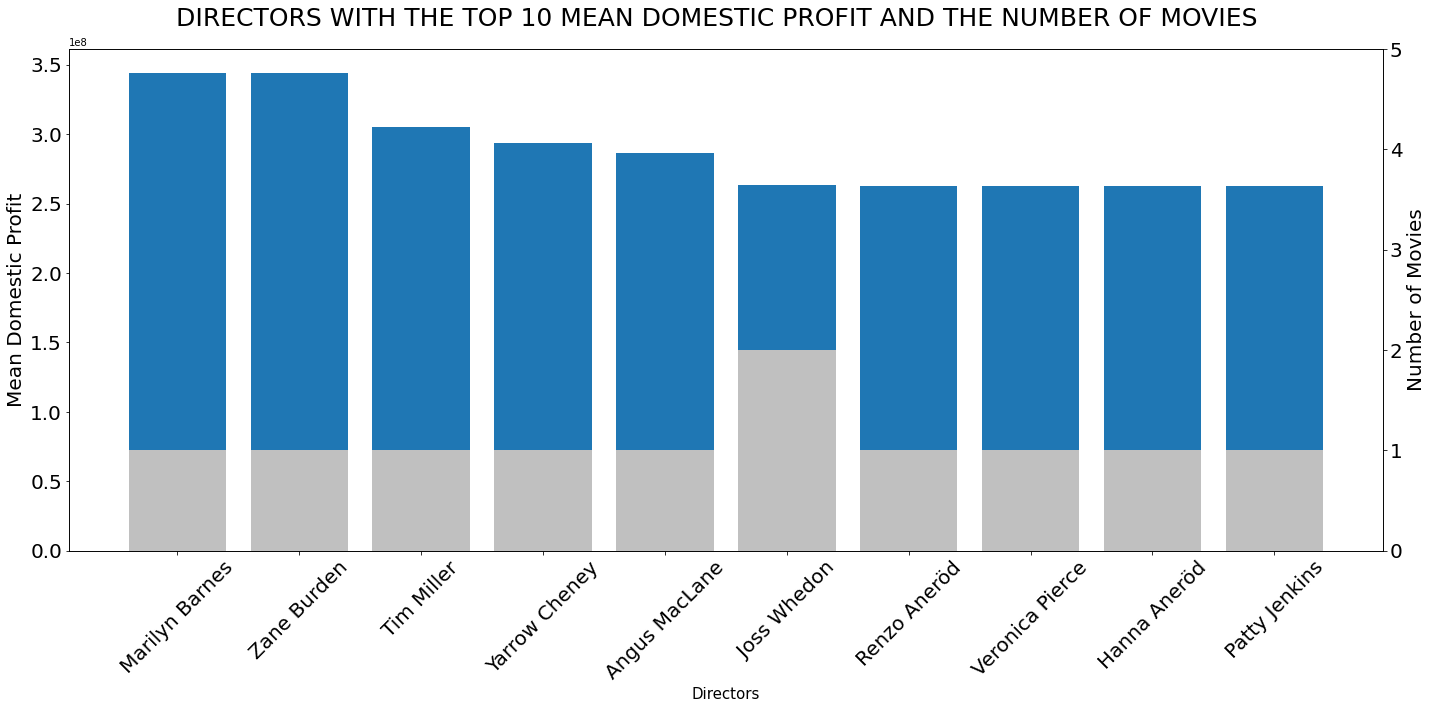

In [59]:
# calculating the mean domestic profit for each associated director and selecting the top 10
directors_domestic = dir_name_profit.groupby('director_name')['domestic_profit'].mean().sort_values(ascending=False)[:10]

# for loop to get the number of movies per director in the top 10 mean domestic profits
dir_dmovie = {}
for name in directors_domestic.index:
    if name in dict(dir_name_profit['director_name']).values():
        num = list(dir_name_profit['director_name']).count(name)
        if name not in dir_dmovie:
            dir_dmovie[name] = num

#barplot showing the directors on the x axis, the mean worldwide profit on the left y axis and the number of movies
# involved in this data analysis on the right y axis          
y1 = directors_domestic.values
y2 = dir_dmovie.values()
x = directors_domestic.index
fig, ax1 = plt.subplots(figsize=(20, 10))

rects1 = ax1.bar(x, y1)
ax1.set_xlabel('Directors', fontsize = 15)
ax1.set_ylabel('Mean Domestic Profit', fontsize = 20)
ax1.tick_params(axis='x', labelsize= 20, rotation=45)
plt.yticks(fontsize=20)


ax2 = ax1.twinx()  
rects2 = ax2.bar(x, y2, color = 'silver')
plt.yticks(np.arange(6), fontsize=20)
ax2.set_ylabel('Number of Movies', fontsize = 20)

plt.suptitle('DIRECTORS WITH THE TOP 10 MEAN DOMESTIC PROFIT AND THE NUMBER OF MOVIES', fontsize= 25)
fig.tight_layout() 
plt.show()


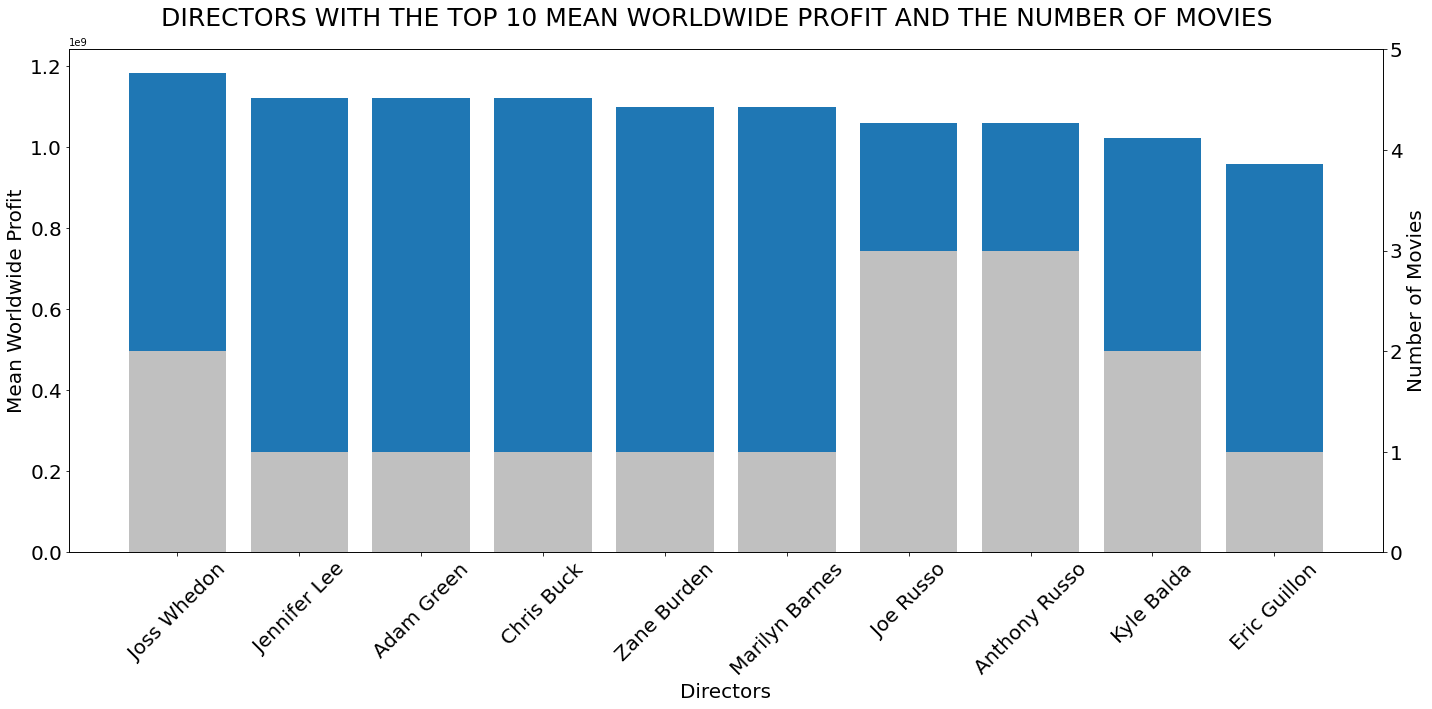

In [58]:
# calculating the mean worldwide profit for each associated director and selecting the top 10
directors_worldwide = dir_name_profit.groupby('director_name')['worldwide_profit'].mean().sort_values(ascending=False)[:10]

# for loop to get the number of movies per director in the top 10 mean worldwide profits
dir_wmovie = {}
for name in directors_worldwide.index:
    if name in dict(dir_name_profit['director_name']).values():
        num = list(dir_name_profit['director_name']).count(name)
        if name not in dir_wmovie:
            dir_wmovie[name] = num  
#barplot showing the directors on the x axis, the mean worldwide profit on the left y axis and the number of movies
# involved in this data analysis on the right y axis
y1 = directors_worldwide.values
y2 = dir_wmovie.values()
x = directors_worldwide.index
fig, ax1 = plt.subplots(figsize=(20, 10))

rects1 = ax1.bar(x, y1)
ax1.set_xlabel('Directors', fontsize = 20)
ax1.set_ylabel('Mean Worldwide Profit', fontsize = 20)
ax1.tick_params(axis='x', labelsize= 20, rotation=45)
plt.yticks(fontsize=20)

ax2 = ax1.twinx()  
rects2 = ax2.bar(x, y2, color = 'silver')
plt.yticks(np.arange(6), fontsize=20)
ax2.set_ylabel('Number of Movies', fontsize = 20)

plt.suptitle('DIRECTORS WITH THE TOP 10 MEAN WORLDWIDE PROFIT AND THE NUMBER OF MOVIES', fontsize= 25)
fig.tight_layout() 
plt.show()